In [58]:
import os
import json
import pandas as pd

In [59]:
folder_base = './results'
folder_baseline = './results_baseline'

csv_file = 'results_summary.csv'


In [60]:
# Define a function to process a single file
def process_file(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    # Extract columns, using placeholders for missing data
    scenario_name = data.get("model_file", "-").replace('.json', '')
    algorithm = data.get("configuration", {}).get("algorithm", "-")
    size = data.get("configuration", {}).get("size", "-")
    optimizer = data.get("configuration", {}).get("optimizer", "-")
    annealings = data.get("configuration", {}).get("nonlinear_annealings", "-")
    iterations = data.get("configuration", {}).get("nonlinear_iterations", "-")

    reasoner = data.get("reasoner_results", {})
    if isinstance(reasoner, str):
        print(f"File {filepath} has reasoner results as a string, converting to dict.")
        reasoner = {"status": reasoner}
    status = reasoner.get("status", "-")
    score = reasoner.get("score", "-")
    evaluation = reasoner.get("evaluation", "-")
    exec_time = reasoner.get("solver_exec_time", "-")
    total_cost = reasoner.get("total_cost", "-")
    max_time = reasoner.get("max_time", "-")
    dispatch = reasoner.get("dispatch", {})

    if optimizer == "linear":
        baseline = "qb-linear"
    elif optimizer == "nonlinear":
        baseline = "qb-nonlinear"
    else:
        baseline = "unknown"
    
    # Row for DataFrame
    row = {
        "baseline": baseline,
        "scenario_name": scenario_name,
        "algorithm": algorithm,
        "size": size,
        "optimizer": optimizer,
        "annealings": annealings,
        "iterations": iterations,
        "status": status,
        "score": score,
        "evaluation": evaluation,
        "exec_time": exec_time,
        "total_cost": total_cost,
        "max_time": max_time,
    }
    
    # Key for dispatches dict
    dispatch_key = (scenario_name, algorithm, size, optimizer, annealings, iterations)
    
    return row, dispatch_key, dispatch

In [61]:
def process_file_baseline(filepath, scenario_name):
    with open(filepath, 'r') as f:
        data = json.load(f)
    algorithm = data.get("algorithm", "-")
    size = data.get("size", "-")
    optimizer = "-"  
    annealings = "-"
    iterations = "-"
    status = "-" 
    score = "-"
    evaluation =  data.get(scenario_name+"_value", "-")
    exec_time = "-"
    total_cost = data.get("total_cost", "-")
    max_time = data.get("max_time", "-")
    dispatch = data.get("dispatch", {})
    baseline = os.path.basename(filepath).replace(algorithm+"_", "").replace(str(size)+"_", "").replace(".json", "")
    row = {
        "baseline": baseline,
        "scenario_name": scenario_name,
        "algorithm": algorithm,
        "size": size,
        "optimizer": optimizer,
        "annealings": annealings,
        "iterations": iterations,
        "status": status,
        "score": score,
        "evaluation": evaluation,
        "exec_time": exec_time,
        "total_cost": total_cost,
        "max_time": max_time
    }
    dispatch_key = (scenario_name, algorithm, size, optimizer, annealings, iterations)
    return row, dispatch_key, dispatch

In [62]:
data_rows = []
dispatches = {}

if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)    
else:
    base_files = [os.path.join(folder_base, f) for f in os.listdir(folder_base) if f.endswith('.json')]
    baseline_files = [os.path.join(folder_baseline, f) for f in os.listdir(folder_baseline) if f.endswith('.json')]
    for file in base_files:
        row, key, dispatch = process_file(file)
        data_rows.append(row)
        dispatches[key] = dispatch
    
    for file in baseline_files:
        for scenario_name in ["scenario1", "scenario2", "scenario3"]:
            row, key, dispatch = process_file_baseline(file, scenario_name)
            data_rows.append(row)
            if key in dispatches:
                continue
            else:
                dispatches[key] = dispatch

    # Create DataFrame
    df = pd.DataFrame(data_rows)

    # Show results
    print("DataFrame:")
    display(df)

    #print("\nDispatches dictionary (keys and values):")
    #for k, v in dispatches.items():
    #    print(f"{k}: {v}")

    # if csv is already present, skip saving
    if not os.path.exists(csv_file):
        df.to_csv(csv_file, index=False)

In [63]:
df.columns

Index(['baseline', 'scenario_name', 'algorithm', 'size', 'optimizer',
       'annealings', 'iterations', 'status', 'score', 'evaluation',
       'exec_time', 'total_cost', 'max_time'],
      dtype='object')

/tmp/ipykernel_72588/1434216526.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=9)


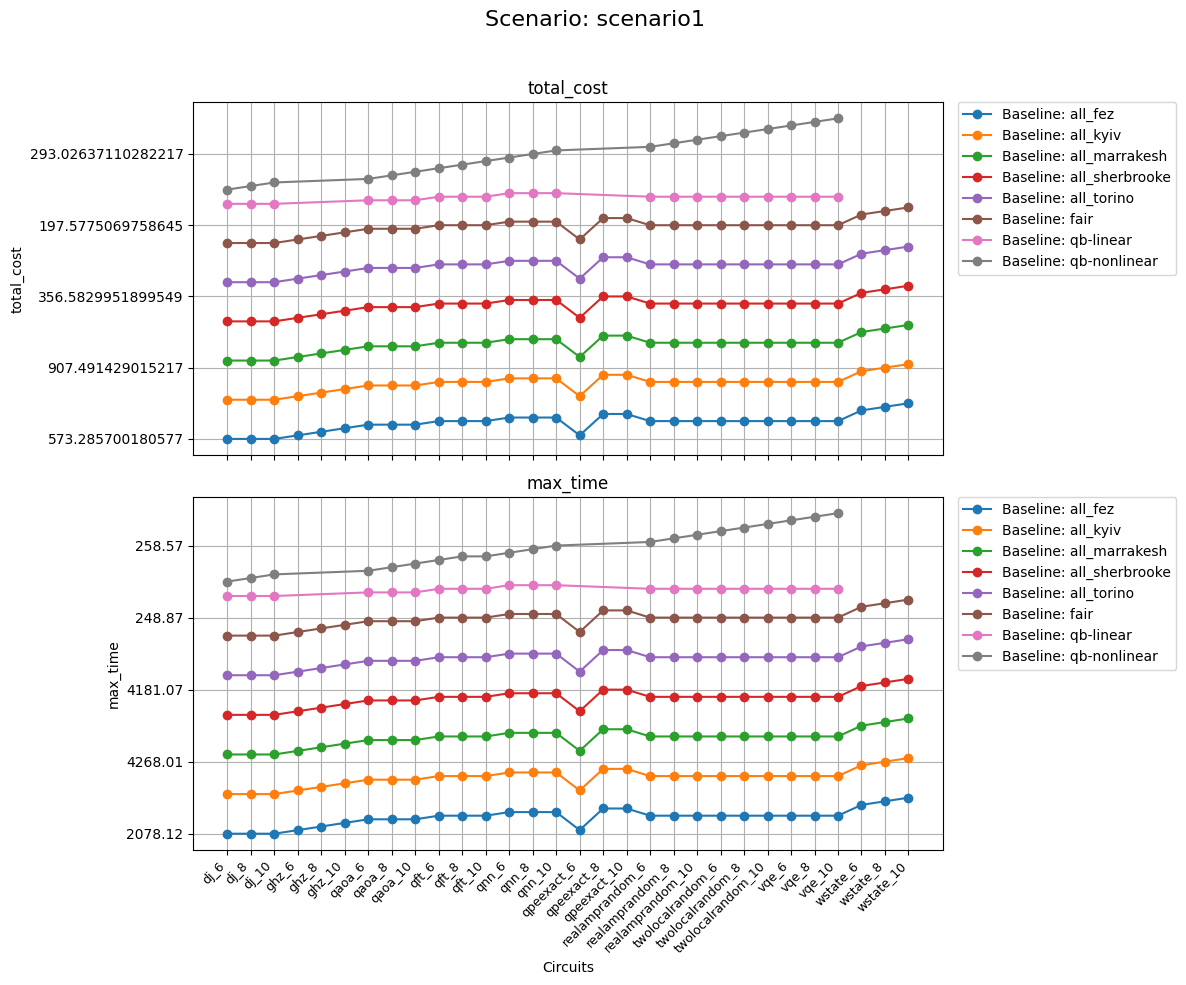

/tmp/ipykernel_72588/1434216526.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=9)


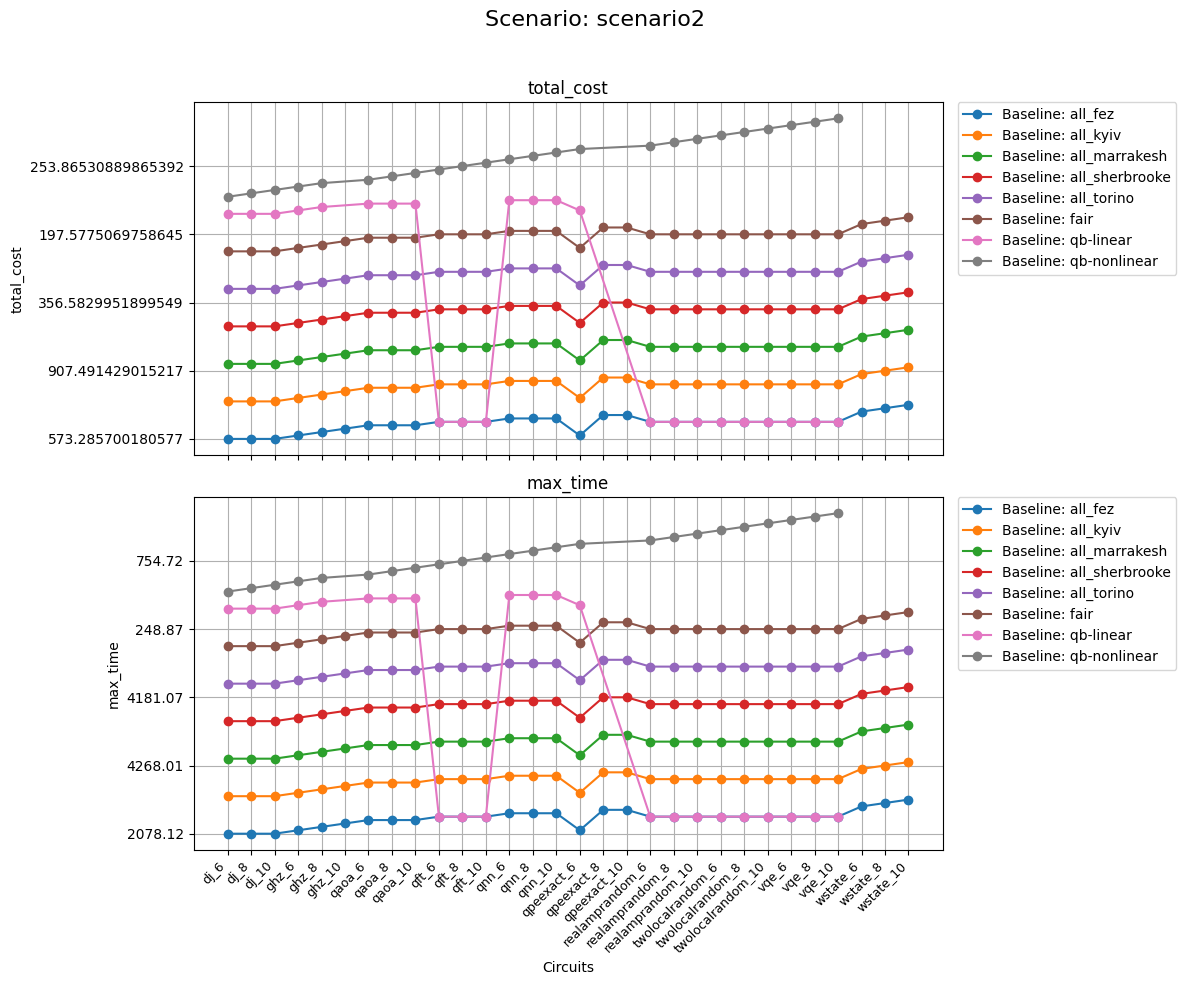

/tmp/ipykernel_72588/1434216526.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=9)


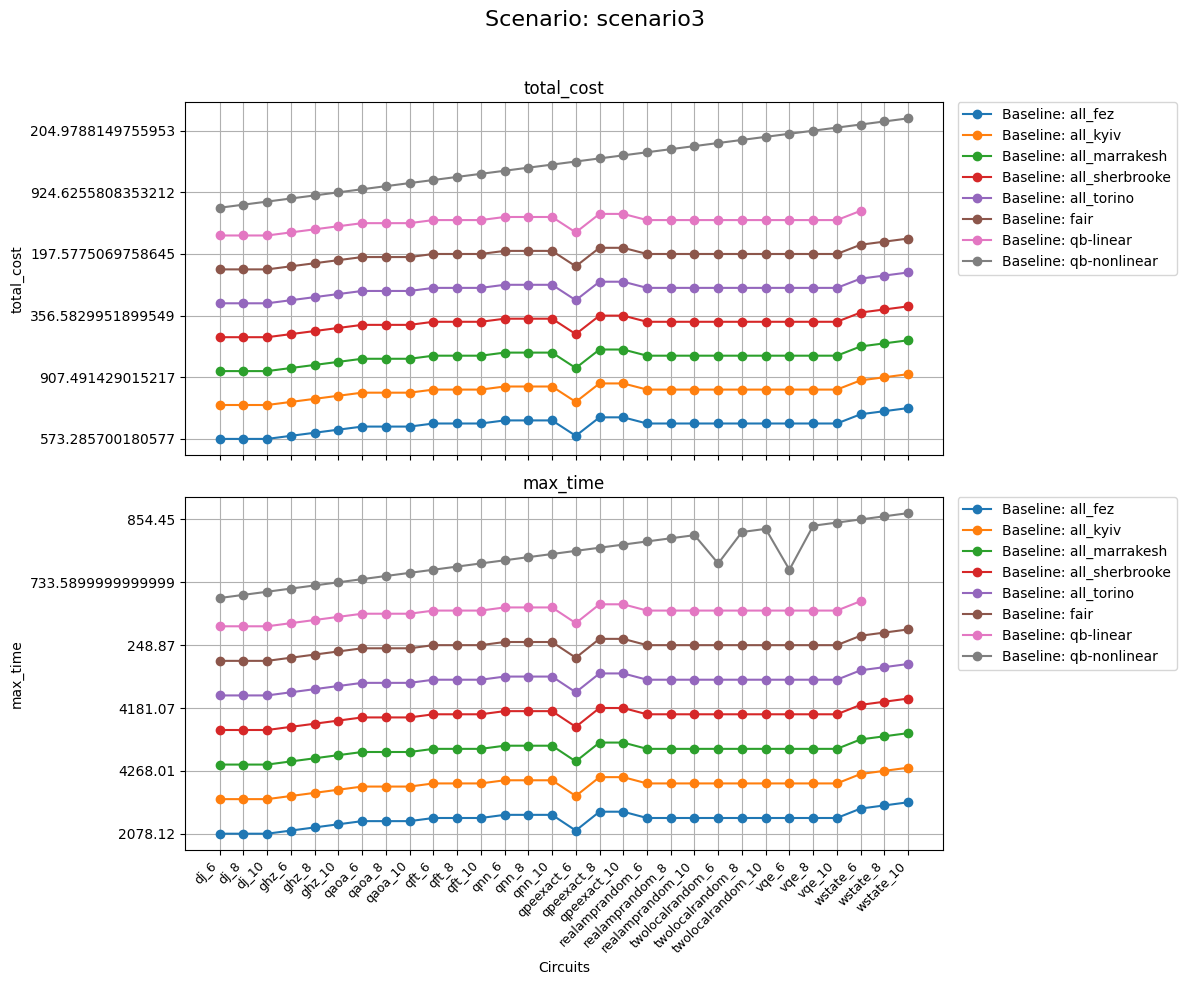

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


_df = df[df['status'].isin(['solution_found', '-'])]


for scenario, group in _df.groupby('scenario_name'):
    # Create composite x labels (algorithm, size)
    group = group.copy()
    group['alg_size'] = group['algorithm'].astype(str) + '_' + group['size'].astype(str)
    
    # Sort to make lines consistent
    group = group.sort_values(['algorithm', 'size'])

    # Set up plots: total_cost and max_time
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(f"Scenario: {scenario}", fontsize=16)

    # One plot for total_cost, one for max_time
    num_ticks = 6

    for i, ycol in enumerate(['total_cost', 'max_time']):
        ax = axes[i]
        for baseline, data in group.groupby('baseline'):
            ax.plot(data['alg_size'], data[ycol], marker='o', label=f'Baseline: {baseline}')
        ax.set_ylabel(ycol)
        ax.set_title(ycol)
        ax.grid(True)
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        
        # Calculate evenly spaced, rounded y-ticks
        ymin, ymax = ax.get_ylim()
        yticks = np.linspace(ymin, ymax, num_ticks)
        yticks = np.round(yticks, 2)  # Round for nicer labels
        ax.set_yticks(yticks)
    
    axes[1].set_xlabel('Circuits')
    # Rotate x-axis labels, set font size smaller
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=9)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
